### SuperVisor Agent with RAG Call and LLM Call

Supervisor function deciding whether to make RAG call to LLM call

In [1]:
# LLM
from langchain_groq import ChatGroq

llm_groq = ChatGroq(model="qwen-qwq-32b")
response = llm_groq.invoke("hi")
print(response.content)


<think>
Okay, the user said "hi". I should respond in a friendly way. Maybe say hello back and ask how I can help them. Keep it simple and open-ended so they feel comfortable to ask anything. Let me check if there's anything else I need to consider. No, just a standard greeting. Alright, ready to respond.
</think>

Hi! 😊 How can I assist you today?


In [2]:
# Embeddings
from langchain_huggingface import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
len(embeddings.embed_query("This is a test sentence."))

/Users/I572648/Library/CloudStorage/OneDrive-SAPSE/Desktop/Git/GenAI/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


384

In [6]:
# Documnent Loaders
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

loader = DirectoryLoader("../data", glob="./*.txt", loader_cls=TextLoader)
docs=loader.load()  # Load the documents

new_docs = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200).split_documents(docs)  # Split the documents into chunks
print(new_docs[0].page_content)  # Access the content of the first chunk
print("-"*20)
print(new_docs[1].page_content)  # Access the content of the second chunk
print("-"*20)
print(new_docs[2].page_content)  # Access the content of the third chunk


🇺🇸 Overview of the U.S. Economy
The United States of America possesses the largest economy in the world in terms of nominal GDP, making it the most powerful economic force globally. It operates under a capitalist mixed economy, where the private sector dominates, but the government plays a significant regulatory and fiscal role. With a population of over 335 million people and a high level of technological advancement, the U.S. economy thrives on a foundation of consumer spending, innovation, global trade, and financial services. It has a highly diversified structure with strong sectors in technology, healthcare, finance, real estate, defense, and agriculture.
--------------------
U.S. GDP – Size, Composition, and Global Share
As of 2024, the United States’ nominal GDP is estimated to be around $28 trillion USD, accounting for approximately 25% of the global economy. It ranks #1 in the world by nominal GDP, far ahead of China (which ranks 2nd). The U.S. GDP per capita is also among the

In [7]:
# Chroma Vector Store
from langchain_community.vectorstores import Chroma

db = Chroma.from_documents(documents=new_docs, embedding=embeddings)  # Create a vector store from the chunks
retriever = db.as_retriever(search_kwargs={"k": 3})  # Create a retriever with k=3
retriever.invoke("Industrial growth of USA?")

[Document(metadata={'source': '../data/usa.txt'}, page_content='Final Summary\nThe U.S. economy remains the engine of global growth, backed by unmatched innovation, financial dominance, and a strong institutional framework. Its $28 trillion GDP and influence over global finance, trade, and technology make it the centerpiece of the modern economic system. Yet, rising debt, inequality, political gridlock, and competition from emerging powers demand careful policy navigation. If successfully addressed, the U.S. will continue to dominate the global economy well into the future.'),
 Document(metadata={'source': '../data/usa.txt'}, page_content='The GDP is predominantly driven by the services sector, which contributes more than 77% to the total GDP. This includes industries such as finance, insurance, real estate, healthcare, education, and information technology. The industrial sector (manufacturing, construction, mining) makes up around 19%, while agriculture, although technologically adva

In [8]:
# Topic Selection Model
from pydantic import BaseModel, Field

# Creation of pydantic class
class TopicSelectionModel(BaseModel):
    Topic: str=Field(description="Selected topic")
    Reasoning: str=Field(description="Reasoning behind topic selection")

In [9]:
# Pydantic Output Parser
from langchain.output_parsers import PydanticOutputParser

parser = PydanticOutputParser(pydantic_object=TopicSelectionModel)
parser.get_format_instructions()

'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"properties": {"Topic": {"description": "Selected topic", "title": "Topic", "type": "string"}, "Reasoning": {"description": "Reasoning behind topic selection", "title": "Reasoning", "type": "string"}}, "required": ["Topic", "Reasoning"]}\n```'

In [13]:
# Agent State with TypedDict
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage
import operator

class AgentState(TypedDict):
    message: Annotated[Sequence[BaseMessage], operator.add]

agent_state = AgentState(message=[])
agent_state

{'message': []}

In [14]:
# Supervisor Agent
from langchain_core.prompts import PromptTemplate

def supervisor(state: AgentState):
    question=state["message"][-1]
    print("Question:", question)

    template= """
    Your task is to classify the given user query into the following categories: [USA,Not Related].
    Only respond with the category name and nothing else.

    User query: {question}
    {format_instructions}
    """

    prompt = PromptTemplate(
        template=template,
        input_variables=["question"],
        partial_variables={"format_instructions": parser.get_format_instructions()}
    )
    chain = prompt | llm_groq | parser
    response = chain.invoke({"question": question})
    print("Response:", response)
    return {"message": [response.Topic]}

In [15]:
state = {"message": ["What is todays weather in USA"]}
supervisor(state)

Question: What is todays weather in USA
Response: Topic='USA' Reasoning="The query explicitly mentions 'USA' and asks about the weather within that country, making it directly related to the USA category."


{'message': ['USA']}

In [16]:
def router(state:AgentState):
    print(" -> ROUTER -> ")
    last_message = state["message"][-1]
    print("Message:", last_message)

    if "USA" in last_message:
        print("USA detected, routing to function1")
        return "RAG CALL"
    else:
        print("No USA detected, returning empty response")
        return "LLM CALL"

In [18]:
# RAG call
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

def rag_call(state: AgentState):
    print(" -> RAG CALL -> ")
    question = state["message"][0]
    print("Question:", question)
    prompt = PromptTemplate(
        template="""
        You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question.
        If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
        Question: {question} 
        context: {context}
        Answer: """,        
        input_variables=["context", "question"]
    )

    rag_chain = (
        {"context": retriever | format_docs, "question": RunnablePassthrough()}
        | prompt 
        | llm_groq
        | StrOutputParser()
    )
    result = rag_chain.invoke(question)
    return {"message": [result]}

In [19]:
state = {"message": ["What is todays weather in USA"]}
rag_call(state)

 -> RAG CALL -> 
Question: What is todays weather in USA


{'message': ["\n<think>\nOkay, the user is asking about today's weather in the USA. Let me check the provided context. Hmm, looking through the information given, it's all about the U.S. economy, structural issues, GDP, global role, etc. There's no mention of weather at all. The contexts are from 2024 but focus on economic data, not current weather conditions. Since the question is about today's weather and the contexts don't provide any relevant info, I can't answer that. I should inform the user that I don't have access to real-time weather data.\n</think>\n\nI don't have access to real-time weather data. The provided context only discusses the U.S. economy, structural challenges, and global economic standing, not current weather conditions. Please check a weather service or app for up-to-date information."]}

In [20]:
# LLM call
def llm_call(state: AgentState):
    print(" -> LLM CALL -> ")
    question = state["message"][0]
    print("Question:", question)
    # Normal LLM call
    complete_query = "Answer the follow question with your knowledge of the real world. Followings is the user question: " + question
    response = llm_groq.invoke(complete_query)
    return {"message": [response.content]}

In [21]:
state = {"message": ["what is blackhole?"]}
llm_call(state)

 -> LLM CALL -> 
Question: what is blackhole?


{'message': ['\n<think>\nOkay, so the user is asking, "What is a black hole?" I need to explain this clearly and simply. Let me start by recalling what I know about black holes. \n\nFirst, black holes are regions in space where gravity is so strong that nothing can escape, not even light. That\'s why they\'re called "black" because they don\'t emit light. But how do they form? I think they come from the remnants of massive stars after a supernova explosion. When a huge star dies, its core collapses under gravity, and if it\'s massive enough, it becomes a black hole.\n\nWait, there\'s also something about the event horizon. That\'s the boundary around a black hole beyond which nothing can escape. The point at the center is the singularity, which is a point of infinite density. But maybe I should mention that the density is so high because all the mass is compressed into an incredibly small space.\n\nHmm, maybe I should mention different types of black holes. Like stellar-mass black hole

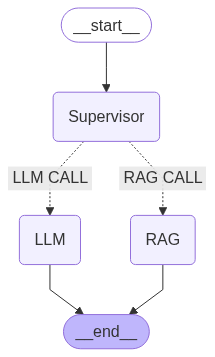

In [23]:
from langgraph.graph import StateGraph, START, END

workflow = StateGraph(AgentState)
workflow.add_node("Supervisor", supervisor)
workflow.add_node("RAG", rag_call)
workflow.add_node("LLM", llm_call)

workflow.set_entry_point("Supervisor")
workflow.add_conditional_edges("Supervisor", 
                               router, 
                               {
                                   "RAG CALL": "RAG",
                                   "LLM CALL": "LLM"
                               }
                               )
workflow.add_edge("LLM", END)
workflow.add_edge("RAG", END)
app = workflow.compile()
app.get_graph()
app

In [24]:
state = {"message": ["can you tell me about india"]}
result = app.invoke(state)
result["message"][-1]

Question: can you tell me about india
Response: Topic='Not Related' Reasoning="The user query specifically mentions 'India', which is a different country from the USA, hence not related."
 -> ROUTER -> 
Message: Not Related
No USA detected, returning empty response
 -> LLM CALL -> 
Question: can you tell me about india


'\n<think>\nOkay, the user is asking me to tell them about India. I need to cover various aspects to give a comprehensive overview. Let me start by thinking about India\'s key points. \n\nFirst, the basic facts: India is a country in South Asia, the seventh-largest by area and second-most populous. It\'s the world\'s most populous democracy. I should mention its name in Hindi, Bharat, and other regional languages. \n\nGeography: The country has diverse landscapes like the Himalayas in the north, the Thar Desert, the Ganges river system, and the Indian Ocean coastline. Maybe touch on the different climate zones, like tropical monsoon, which brings the monsoons.\n\nCulture and history: Ancient civilizations like the Indus Valley, Vedic period, Mughal era, British colonial period, and independence in 1947. The cultural diversity with numerous languages, religions, festivals like Diwali and Holi, and traditional practices.\n\nGovernment and politics: It\'s a federal parliamentary democrati

In [27]:
for output in app.stream(state):
    print("Output:", output)

Question: can you tell me about india
Response: Topic='Not Related' Reasoning='The user query asks about India, which is not the USA. Therefore, it is unrelated to the USA category.'
 -> ROUTER -> 
Message: Not Related
No USA detected, returning empty response
Output: {'Supervisor': {'message': ['Not Related']}}
 -> LLM CALL -> 
Question: can you tell me about india
Output: {'LLM': {'message': ['\n<think>\nOkay, the user is asking me to tell them about India. I need to provide a comprehensive overview, but not too detailed. Let me start by thinking about the main aspects of India. Geography, history, culture, economy, maybe some key facts.\n\nFirst, India\'s full name is the Republic of India. It\'s located in South Asia. I should mention its neighboring countries: Pakistan, China, Nepal, Bhutan, Bangladesh, Afghanistan maybe? Wait, Afghanistan is a bit farther north, maybe not directly bordering. Let me confirm that. Yes, India\'s borders are with Pakistan to the west, China, Nepal, B